# Stochastic gradient descent

Author: Pierre Ablin
   
## General framework

Consider the task of learning a map $x\to y$ from a training dataset $(x_1, y_1), \dots, (x_n, y_n)$. To do so, we use a parametrized model $f_{w}(x)$ that tries to predict $y$. Here, $w$ are the parameters. The parameters are learned by doing *empirical risk minimization*:
$$
w\in\arg\min F(w) = \frac1n\sum_{i=1}^n f_i(w), \enspace \text{with} \enspace f_i(w) = \ell(f_w(x_i), y_i).
$$
Here, $\ell$ is a function that measures a discrepancy in the space of $y$.

## Examples
For instance, when doing regression, i.e. when $y\in\mathbb{R}$ we can use $\ell(y', y) = \frac12(y - y')^2$. When doing binary classification, i.e. when $y\in \pm 1$, we can use the logistic loss
$\ell(y', y) = \log(1+\exp(-y'y))$.

When the model $f_w$ is linear, we are doing linear regression / classification: $f_w(x) = \langle w, x\rangle$.

## Sum structure

We want to minimize $F$, which has a sum structure. We can for instance use gradient descent, starting from $w^0$:

For $t = 0\dots T$:
$$
w^{t+1} = w^t - \rho \nabla F(w^t) = w^t  - \frac{\rho}{n}\sum_{i=1}^n \nabla f_i(w^t).
$$

However, doing one step of gradient descent requires computing all the $\nabla f_i(w^t)$, which is extremely costly when $n$ is large. This is the case in many areas of machine learning, where the datasets are big, like image processing or natural language processing.

## Stochastic gradient descent (SGD)

An appealing alternative is to use the gradient coming from only one of the $f_i$, where $i$ is chosen at random at each iteration


For $t = 0\dots T$:
$$
w^{t+1} = w^t - \rho \nabla f_i(w^t), \enspace i \sim U(1, n)
$$
This algorithm is called Stochastic Gradient Descent (SGD). It is one of the most important optimization algorithm in datascience, since it is the main algorithm to train neural networks.


**Question 0**: Imagine that we duplicate the training set, so that now we have a dataset of size $2n$ with copies of the original dataset. What happens for gradient descent? What happens for SGD?
## Batch size

In order to leverage the parallelism offered by the computing hardware, it is often more efficient to use a mini-batch rather than a single stochastic gradient: we compute the average of $b$ gradients, where $b$ is the batch size.


For $t = 0\dots T$:
$$
w^{t+1} = w^t - \frac{\rho}{b}\sum_{j=1}^b \nabla f_{i^j}(w^t), \enspace (i^j) \sim P(b, n)
$$
where $P(b, n)$ is the uniform distribution of sets of $b$ integers in $\{1, n\}$.

Like this, taking $b=1$ recoves SGD, and $b= n$ recovers gradient descent.

We will implement it for the ridge regression problem.

## Ridge regression

For ridge regression, we have 

$$
F(w) = \frac1n\|Xw - y\|^2 + \lambda \|w\|^2
$$

where $X$ is the data matrix of size $n\times p$ and $y$ the target vector of size $n$.


**Question 1**: For this problem, what is $f_i(w)$?

Below we implement SGD with mini-batch for this problem.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from time import time


n = 1000
p = 20

X = np.random.randn(n, p)
y = np.random.randn(n)
lbda = 0.1


def ridge_loss(w, X, y, lbda):
    n, p = X.shape
    res = np.dot(X, w) - y
    return 0.5 * (np.dot(res, res) / n + lbda * np.dot(w, w))


def ridge_solution(X, y, lbda):
    n, p = X.shape
    K = np.dot(X.T, X) + lbda * n * np.eye(p)
    return np.linalg.solve(K, np.dot(X.T, y))


# We define below a function that computes the gradient associated to a mini-batch

def stochastic_gradient(w, X, y, lbda, batch_size):
    n, p = X.shape
    idx = np.random.choice(n, batch_size, replace=False)
    X_batch = X[idx]
    y_batch = y[idx]
    residuals = np.dot(X_batch, w) - y_batch
    grad = 1 / batch_size * np.dot(X_batch.T, residuals) + lbda * w
    return grad

In [14]:
def ridge_sgd(w0, X, y, lbda, batch_size, step_size, n_iters=10000):
    w = w0.copy()
    w_list = []
    for i in range(n_iters):
        grad = stochastic_gradient(w, X, y, lbda, batch_size)
        w = w - step_size * grad
        w_list.append(w.copy())
    return w, w_list

SyntaxError: invalid syntax (1722139382.py, line 1)

Text(0, 0.5, 'error')

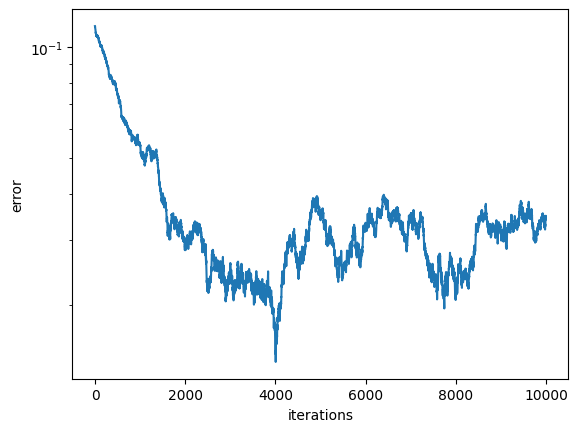

In [15]:
w, w_list = ridge_sgd(np.zeros(p), X, y, lbda, batch_size=10, step_size=.001,
                      n_iters=10000)
w_star = ridge_solution(X, y, lbda)
dists = [np.linalg.norm(w - w_star) for w in w_list]
plt.semilogy(dists)
plt.xlabel('iterations')
plt.ylabel('error')

We see two phases: first, a fast decay, and then a plateau.

**Question 2**: Investigate the behavior of SGD with different batch size and step size.

Text(0, 0.5, 'error')

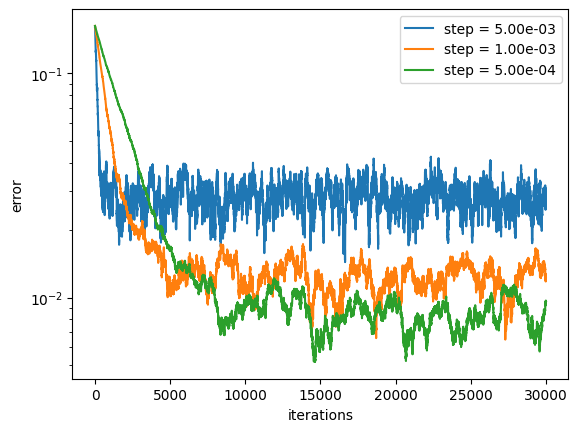

In [10]:
steps = [0.005, 0.001, 0.0005] # Loop over step sizes
for step in steps:
    w, w_list = ridge_sgd(np.zeros(p), X, y, lbda, batch_size=50, step_size=step,
                          n_iters=30000)
    w_star = ridge_solution(X, y, lbda)
    dists = [np.linalg.norm(w - w_star) for w in w_list]
    plt.semilogy(dists, label='step = %.2e' % step)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('error')

We see that larger step-sizes leads to faster convergence in the beginning, and higher plateau. This is well explained by theory.

Text(0, 0.5, 'error')

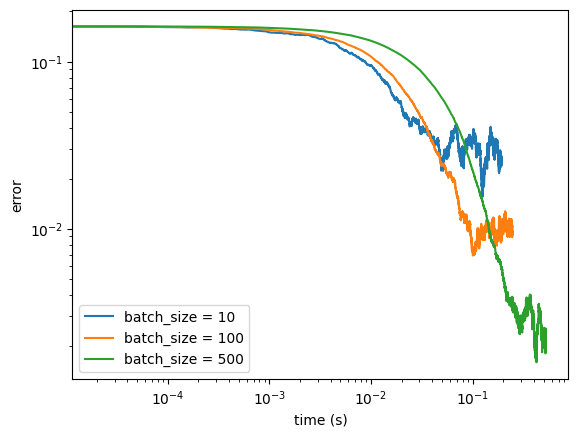

In [12]:
batch_sizes = [10, 100, 500]  # Loop over batch sizes, and record time it takes to run the algorithm
n_iters = 10000
for batch_size in batch_sizes:
    t0 = time()
    w, w_list = ridge_sgd(np.zeros(p), X, y, lbda, batch_size=batch_size, step_size=1e-3,
                          n_iters=n_iters)
    t1 = time() - t0
    w_star = ridge_solution(X, y, lbda)
    dists = [np.linalg.norm(w - w_star) for w in w_list]
    time_scale = np.linspace(0, t1, n_iters)
    plt.semilogy(time_scale, dists, label='batch_size = %d' % batch_size)
plt.legend()
plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel('error')

Here, using a smaller batch size does not necessarily improves things, because of parrallelism.